<a href="https://colab.research.google.com/github/VMKVallabhaneni/aml/blob/main/Assignment2_G11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the data

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gundedivya1696","key":"7b1a8c70690bee411f393df3ec878ec3"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:27<00:00, 33.7MB/s]
100% 812M/812M [00:27<00:00, 31.2MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

#Transferring pictures to test, validation, and training folders and intially considering 1000 for train, 500 for test and 500 for validation

In [7]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_1000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 1000),
    "validation": (1000, 1500),
    "test": (1500, 2000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

**Configuring the model for training**

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training = 1000; Validation = 500; Test = 500

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [12]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [13]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [14]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [15]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


#Displaying the shapes of the data and labels yielded by the Dataset

In [16]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


#Fitting the model using a Dataset

In [17]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/20
63/63 [==============================] - 12s 84ms/step - loss: 0.6963 - accuracy: 0.5010 - val_loss: 0.6934 - val_accuracy: 0.4910
Epoch 2/20
63/63 [==============================] - 4s 61ms/step - loss: 0.6897 - accuracy: 0.5430 - val_loss: 0.6926 - val_accuracy: 0.5180
Epoch 3/20
63/63 [==============================] - 3s 41ms/step - loss: 0.6830 - accuracy: 0.5595 - val_loss: 0.6935 - val_accuracy: 0.5200
Epoch 4/20
63/63 [==============================] - 4s 57ms/step - loss: 0.6732 - accuracy: 0.5905 - val_loss: 0.6633 - val_accuracy: 0.6000
Epoch 5/20
63/63 [==============================] - 4s 59ms/step - loss: 0.6368 - accuracy: 0.6445 - val_loss: 0.6450 - val_accuracy: 0.6370
Epoch 6/20
63/63 [==============================] - 4s 58ms/step - loss: 0.5904 - accuracy: 0.6805 - val_loss: 0.6288 - val_accuracy: 0.6860
Epoch 7/20
63/63 [==============================] - 4s 57ms/step - loss: 0.5689 - accuracy: 0.7060 - val_loss: 0.5910 - val_accuracy: 0.6850
Epoch 8/20
6

#Displaying curves of loss and accuracy during training

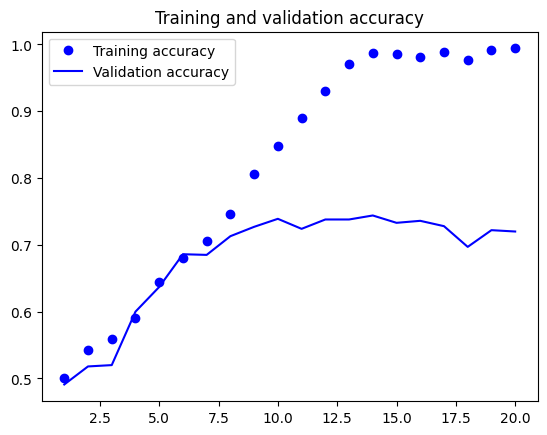

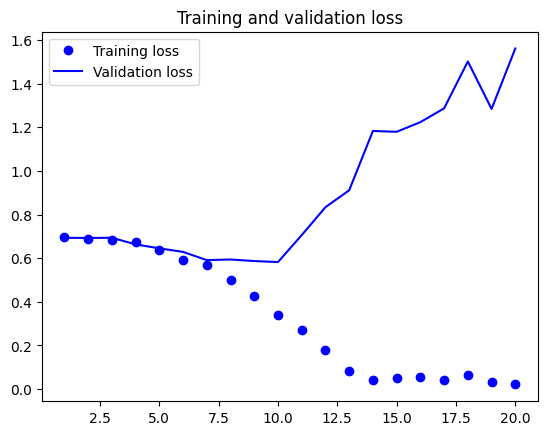

In [18]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#Evaluating the model on the test set

In [19]:
test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 14ms/step - loss: 0.6449 - accuracy: 0.7060
Test accuracy: 0.706


#Transferring pictures to test, validation, and training folders and intially considering 2000 for train, 500 for test and 500 for validation

In [20]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_2000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 2000),
    "validation": (2000, 2500),
    "test": (2500, 3000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

**Configuring the model for training**

In [23]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training = 2000; Validation = 500; Test = 500

In [24]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [25]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [26]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [27]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [28]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [29]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a Dataset**

In [30]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
125/125 [==============================] - 8s 48ms/step - loss: 0.6873 - accuracy: 0.5395 - val_loss: 0.6868 - val_accuracy: 0.5390
Epoch 2/10
125/125 [==============================] - 6s 49ms/step - loss: 0.6542 - accuracy: 0.6130 - val_loss: 0.5988 - val_accuracy: 0.7020
Epoch 3/10
125/125 [==============================] - 6s 46ms/step - loss: 0.6045 - accuracy: 0.6718 - val_loss: 0.5827 - val_accuracy: 0.7010
Epoch 4/10
125/125 [==============================] - 5s 38ms/step - loss: 0.5686 - accuracy: 0.7107 - val_loss: 0.5885 - val_accuracy: 0.6990
Epoch 5/10
125/125 [==============================] - 6s 46ms/step - loss: 0.5452 - accuracy: 0.7240 - val_loss: 0.5617 - val_accuracy: 0.7360
Epoch 6/10
125/125 [==============================] - 6s 46ms/step - loss: 0.4826 - accuracy: 0.7765 - val_loss: 0.5137 - val_accuracy: 0.7700
Epoch 7/10
125/125 [==============================] - 6s 46ms/step - loss: 0.4311 - accuracy: 0.7968 - val_loss: 0.5127 - val_accuracy: 0.7560

**Displaying curves of loss and accuracy during training**

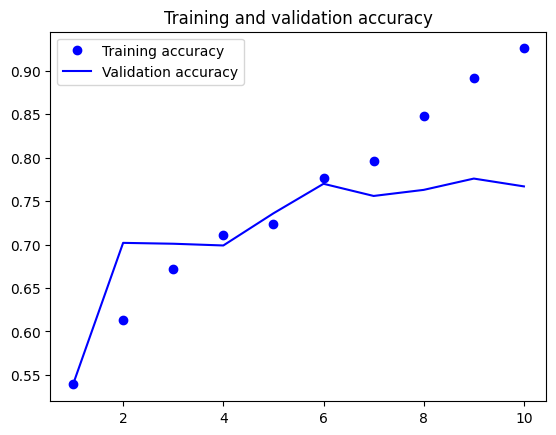

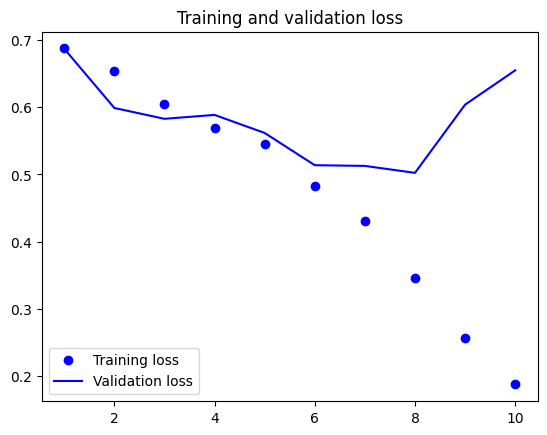

In [31]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [32]:
test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 13ms/step - loss: 0.5867 - accuracy: 0.7330
Test accuracy: 0.733


#Transferring pictures to test, validation, and training folders and intially considering 3000 for train, 500 for test and 500 for validation

In [33]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_3000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 3000),
    "validation": (3000, 3500),
    "test": (3500, 4000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [34]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [35]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                     

**Configuring the model for training**

In [36]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training = 3000; Validation = 500; Test = 500

In [37]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [38]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [39]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [40]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [41]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [42]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [43]:
#model.compile(optimizer='adam', loss='mean_squared_error')


**Fitting the model using a `Dataset`**

In [44]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
188/188 [==============================] - 10s 44ms/step - loss: 0.6688 - accuracy: 0.5780 - val_loss: 0.6289 - val_accuracy: 0.6260
Epoch 2/10
188/188 [==============================] - 7s 37ms/step - loss: 0.6295 - accuracy: 0.6443 - val_loss: 0.6480 - val_accuracy: 0.6350
Epoch 3/10
188/188 [==============================] - 8s 42ms/step - loss: 0.6107 - accuracy: 0.6622 - val_loss: 0.5904 - val_accuracy: 0.6760
Epoch 4/10
188/188 [==============================] - 8s 44ms/step - loss: 0.5482 - accuracy: 0.7178 - val_loss: 0.5221 - val_accuracy: 0.7400
Epoch 5/10
188/188 [==============================] - 8s 42ms/step - loss: 0.4943 - accuracy: 0.7573 - val_loss: 0.5086 - val_accuracy: 0.7620
Epoch 6/10
188/188 [==============================] - 8s 42ms/step - loss: 0.4581 - accuracy: 0.7797 - val_loss: 0.4756 - val_accuracy: 0.7910
Epoch 7/10
188/188 [==============================] - 8s 42ms/step - loss: 0.4048 - accuracy: 0.8143 - val_loss: 0.4339 - val_accuracy: 0.805

# Evaluating the model on the test set

# **Using data augmentation**

In [46]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Showing some randomly enhanced training pictures

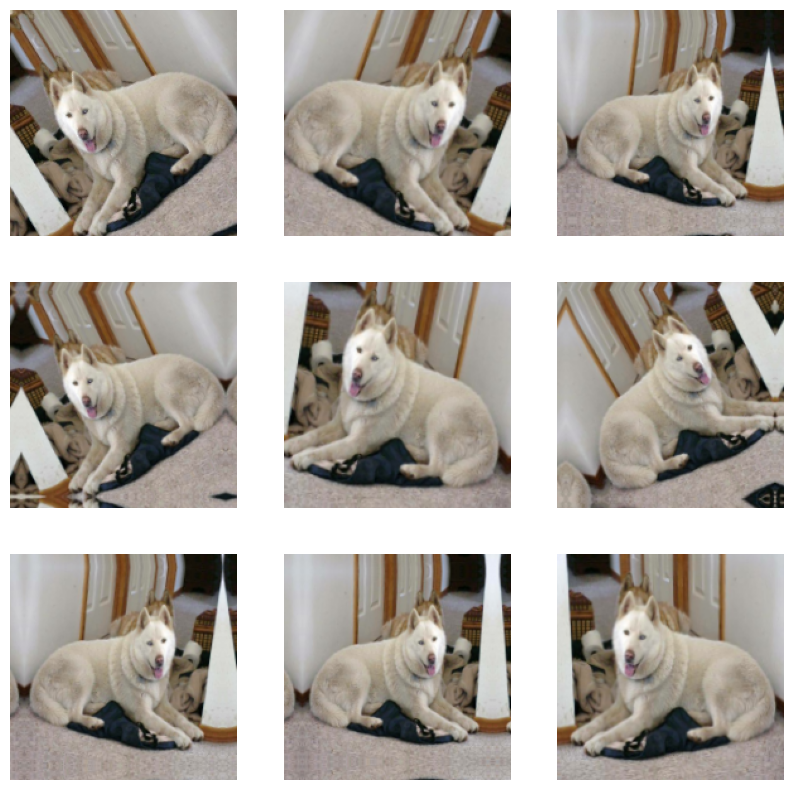

In [47]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **Defining a new convnet that includes image augmentation and dropout**

In [48]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# **Training the regularized convnet**

In [49]:
#Have run with data augmentation for training set of 1000,2000 and 3000
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
188/188 [==============================] - 13s 51ms/step - loss: 0.6920 - accuracy: 0.5092 - val_loss: 0.6777 - val_accuracy: 0.5690
Epoch 2/10
188/188 [==============================] - 10s 52ms/step - loss: 0.6709 - accuracy: 0.5925 - val_loss: 0.6639 - val_accuracy: 0.6010
Epoch 3/10
188/188 [==============================] - 9s 48ms/step - loss: 0.6496 - accuracy: 0.6217 - val_loss: 0.6195 - val_accuracy: 0.6530
Epoch 4/10
188/188 [==============================] - 9s 48ms/step - loss: 0.6185 - accuracy: 0.6723 - val_loss: 0.5898 - val_accuracy: 0.6760
Epoch 5/10
188/188 [==============================] - 9s 49ms/step - loss: 0.5762 - accuracy: 0.6995 - val_loss: 0.5478 - val_accuracy: 0.7100
Epoch 6/10
188/188 [==============================] - 9s 48ms/step - loss: 0.5604 - accuracy: 0.7112 - val_loss: 0.5112 - val_accuracy: 0.7570
Epoch 7/10
188/188 [==============================] - 7s 38ms/step - loss: 0.5391 - accuracy: 0.7300 - val_loss: 0.5417 - val_accuracy: 0.71

# **Evaluating the model on the test set**

In [50]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 14ms/step - loss: 0.5068 - accuracy: 0.7810
Test accuracy: 0.781


# Using a pretrained model


In [51]:
import keras
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [52]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# Feature extraction without data augmentation

In [53]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 23ms/step


#Defining and training the classifier

In [54]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
188/188 [==============================] - 2s 8ms/step - loss: 7.2517 - accuracy: 0.9573 - val_loss: 3.3064 - val_accuracy: 0.9790
Epoch 2/10
188/188 [==============================] - 1s 4ms/step - loss: 3.5688 - accuracy: 0.9793 - val_loss: 5.7785 - val_accuracy: 0.9690
Epoch 3/10
188/188 [==============================] - 1s 4ms/step - loss: 1.3684 - accuracy: 0.9895 - val_loss: 5.0475 - val_accuracy: 0.9730
Epoch 4/10
188/188 [==============================] - 1s 4ms/step - loss: 0.9573 - accuracy: 0.9918 - val_loss: 6.0635 - val_accuracy: 0.9680
Epoch 5/10
188/188 [==============================] - 1s 4ms/step - loss: 0.3019 - accuracy: 0.9968 - val_loss: 6.6209 - val_accuracy: 0.9710
Epoch 6/10
188/188 [==============================] - 1s 4ms/step - loss: 0.4300 - accuracy: 0.9965 - val_loss: 8.9612 - val_accuracy: 0.9710
Epoch 7/10
188/188 [==============================] - 1s 4ms/step - loss: 0.4578 - accuracy: 0.9962 - val_loss: 5.0438 - val_accuracy: 0.9770
Epoch 

# Graphical representation

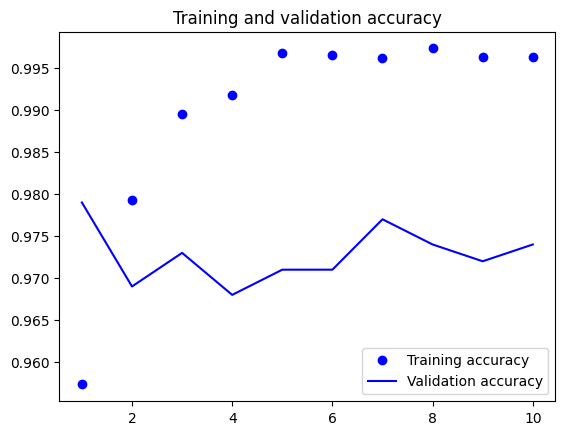

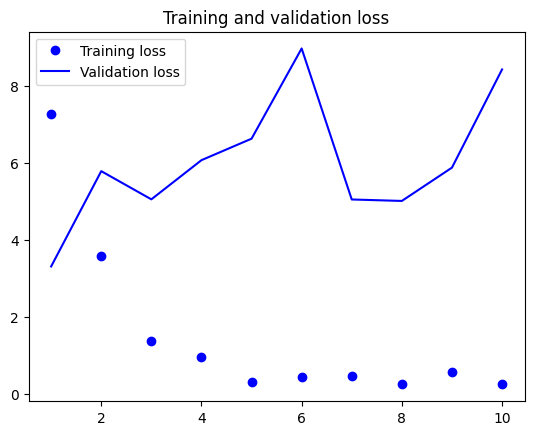

In [55]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [56]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 2ms/step - loss: 6.2801 - accuracy: 0.9770
Test Loss: 6.280123710632324
Test Accuracy: 0.9769999980926514


# Changing optimizer to rmsprop

In [57]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
188/188 [==============================] - 2s 7ms/step - loss: 11.1387 - accuracy: 0.9482 - val_loss: 6.2137 - val_accuracy: 0.9560
Epoch 2/10
188/188 [==============================] - 1s 4ms/step - loss: 3.2524 - accuracy: 0.9787 - val_loss: 14.3667 - val_accuracy: 0.9540
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 2.0499 - accuracy: 0.9853 - val_loss: 4.9468 - val_accuracy: 0.9750
Epoch 4/10
188/188 [==============================] - 1s 4ms/step - loss: 1.1570 - accuracy: 0.9908 - val_loss: 7.4351 - val_accuracy: 0.9760
Epoch 5/10
188/188 [==============================] - 1s 4ms/step - loss: 0.9491 - accuracy: 0.9930 - val_loss: 5.6814 - val_accuracy: 0.9760
Epoch 6/10
188/188 [==============================] - 1s 4ms/step - loss: 0.6680 - accuracy: 0.9943 - val_loss: 5.3833 - val_accuracy: 0.9760
Epoch 7/10
188/188 [==============================] - 1s 4ms/step - loss: 0.7036 - accuracy: 0.9938 - val_loss: 5.9462 - val_accuracy: 0.9790
Epoc

In [58]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 2ms/step - loss: 6.1129 - accuracy: 0.9790
Test Loss: 6.112938404083252
Test Accuracy: 0.9789999723434448


# Feature extraction together with data augmentation

In [59]:
import keras
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

# Printing the trainable weights list both before and after the freezer

In [60]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [61]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


# incorporating a classifier and a data augmentation stage into the convolutional base

In [62]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [63]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
188/188 [==============================] - 28s 139ms/step - loss: 7.6687 - accuracy: 0.9317 - val_loss: 4.0319 - val_accuracy: 0.9700
Epoch 2/10
188/188 [==============================] - 25s 134ms/step - loss: 5.2149 - accuracy: 0.9532 - val_loss: 2.9040 - val_accuracy: 0.9710
Epoch 3/10
188/188 [==============================] - 24s 129ms/step - loss: 3.7543 - accuracy: 0.9622 - val_loss: 1.9278 - val_accuracy: 0.9810
Epoch 4/10
188/188 [==============================] - 25s 134ms/step - loss: 2.2516 - accuracy: 0.9658 - val_loss: 1.6238 - val_accuracy: 0.9740
Epoch 5/10
188/188 [==============================] - 25s 133ms/step - loss: 1.3256 - accuracy: 0.9702 - val_loss: 0.8975 - val_accuracy: 0.9790
Epoch 6/10
188/188 [==============================] - 25s 131ms/step - loss: 0.7945 - accuracy: 0.9773 - val_loss: 0.5107 - val_accuracy: 0.9820
Epoch 7/10
188/188 [==============================] - 25s 134ms/step - loss: 0.5658 - accuracy: 0.9730 - val_loss: 0.4231 - val_ac

# Graphical representation

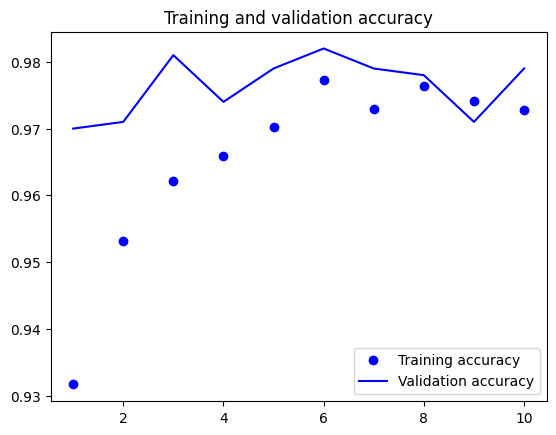

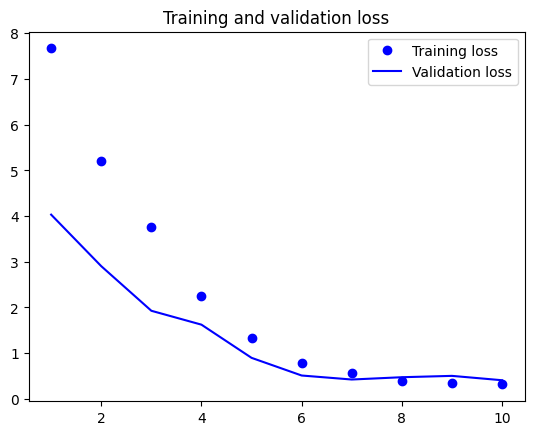

In [64]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Evaluating the model on the test set

In [65]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 95ms/step - loss: 0.5594 - accuracy: 0.9750
Test accuracy: 0.975


In [66]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [67]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
188/188 [==============================] - 27s 133ms/step - loss: 10.6848 - accuracy: 0.9243 - val_loss: 3.4129 - val_accuracy: 0.9710
Epoch 2/10
188/188 [==============================] - 23s 120ms/step - loss: 5.1513 - accuracy: 0.9523 - val_loss: 3.6865 - val_accuracy: 0.9760
Epoch 3/10
188/188 [==============================] - 25s 131ms/step - loss: 4.1265 - accuracy: 0.9567 - val_loss: 1.7249 - val_accuracy: 0.9810
Epoch 4/10
188/188 [==============================] - 22s 118ms/step - loss: 3.0067 - accuracy: 0.9610 - val_loss: 1.7338 - val_accuracy: 0.9810
Epoch 5/10
188/188 [==============================] - 25s 134ms/step - loss: 2.0101 - accuracy: 0.9653 - val_loss: 1.3133 - val_accuracy: 0.9830
Epoch 6/10
188/188 [==============================] - 25s 131ms/step - loss: 1.5187 - accuracy: 0.9617 - val_loss: 0.8314 - val_accuracy: 0.9800
Epoch 7/10
188/188 [==============================] - 25s 131ms/step - loss: 1.0494 - accuracy: 0.9635 - val_loss: 0.3883 - val_a

#Evaluating model on test set

In [68]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 98ms/step - loss: 0.5516 - accuracy: 0.9730
Test accuracy: 0.973
